In [1]:
# ! pip install pandas
# ! pip install seaborn
# ! pip install xgboost
# ! pip install scikit-optimize
# ! pip install openpyxl

In [2]:
import pandas as pd
from lib.lib import *
from sklearn.model_selection import train_test_split

In [3]:
simulated_data = pd.read_excel(f'data/CNT_Growth_Rate_Simulation_with_noise.xlsx')
simulated_data.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,600,0,0.6,0.000000
1,1,600,1,0.6,0.028338
2,1,600,2,0.6,0.076081
3,1,600,3,0.6,0.114440
4,1,600,4,0.6,0.157956


In [4]:
print(simulated_data.shape)
simulated_data.describe()

(163336, 5)


,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
count,163336.000000,163336.000000,163336.000000,163336.000000,163336.000000
mean,68.500000,800.000000,600.000000,1.300000,21.105942
std,39.258877,122.474862,346.699778,0.458259,13.560843
min,1.000000,600.000000,0.000000,0.600000,0.000000
25%,34.750000,700.000000,300.000000,0.950000,9.409286
50%,68.500000,800.000000,600.000000,1.300000,18.133358
75%,102.250000,900.000000,900.000000,1.650000,31.100267
max,136.000000,1000.000000,1200.000000,2.000000,68.093337


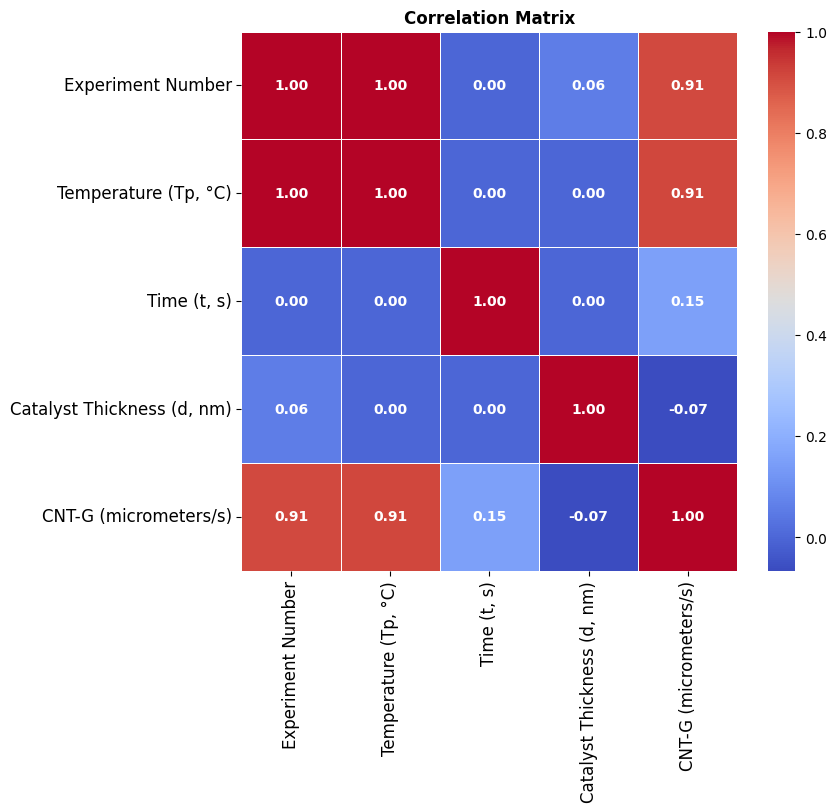

In [5]:
get_data_correlation(simulated_data)

In [6]:
original_data = pd.read_csv('data/CNTGrowthData.csv')
original_data.head()
original_data.rename(columns={
    'Run_ID': 'Experiment Number',
    'Temperature ( in C )': 'Temperature (Tp, °C)',
    'Catalyst Layer Thickness ( in nm )': 'Catalyst Thickness (d, nm)',
    'Time_s': 'Time (t, s)',
    'growth_rate': 'CNT-G (micrometers/s)'
}, inplace=True)
original_data = original_data[list(simulated_data.columns)]
original_data["Experiment Number"] = original_data["Experiment Number"] + max(simulated_data["Experiment Number"])
original_data.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,137,625,132,2,4.520099
1,137,625,134,2,4.490667
2,137,625,136,2,4.503352
3,137,625,138,2,4.573735
4,137,625,140,2,6.329410


In [7]:
full_dataset = pd.concat([simulated_data, original_data], axis=0)
full_dataset.shape

(167802, 5)

In [8]:
simulated_exp, total_exp = max(simulated_data["Experiment Number"]), max(full_dataset["Experiment Number"])
simulated_exp, total_exp

(136, 139)

In [9]:
target = ['CNT-G (micrometers/s)']
features = ['Temperature (Tp, °C)', 'Time (t, s)', 'Catalyst Thickness (d, nm)']

### Train on only simulated data and test simulated

In [10]:
test_experiment_numbers = [3, 19, 37, 100]

# Separate the test set
test_set = simulated_data[simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (4804, 5)


In [11]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  4
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (4804, 3)
Y_test shape: (4804, 1)


In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9854948803678524
MAE CNT-G: 0.8780804719957641
MSE CNT-G: 2.003225880697813
RMSE CNT-G: 1.4153536239038684


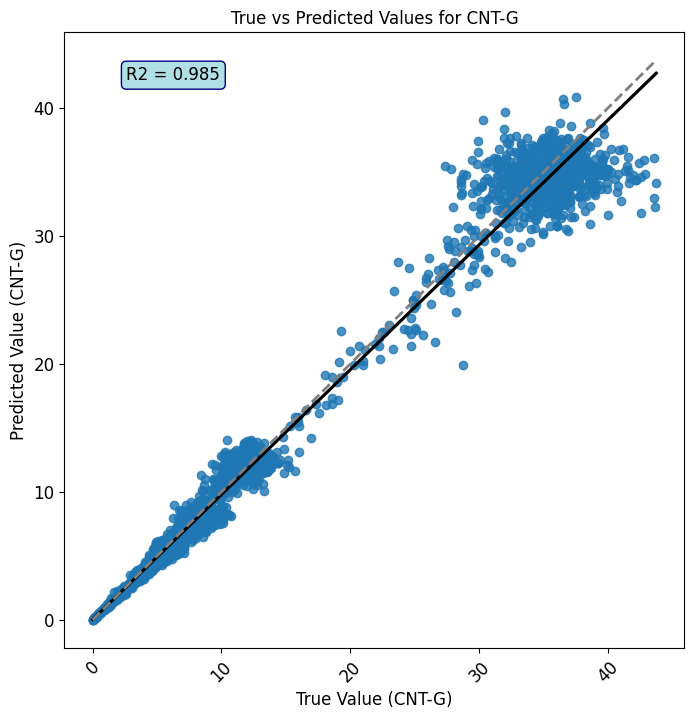

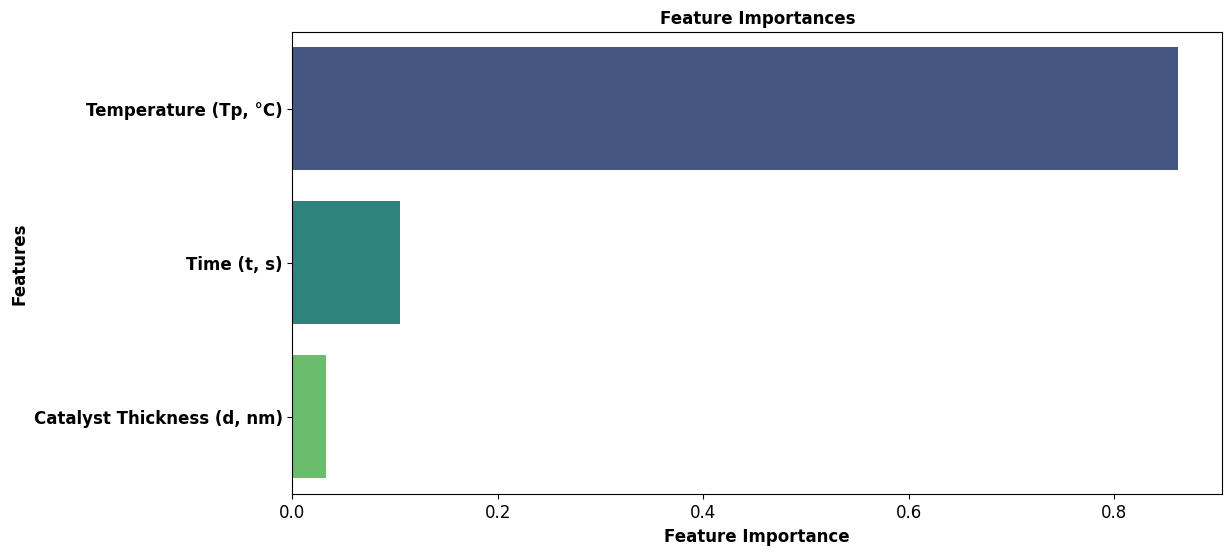

In [13]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)
model_prediction = xgb_model.predict(X_test)

R^2 CNT-G: 0.990364134311676
MAE CNT-G: 0.6526512557111045
MSE CNT-G: 1.3307586082685288
RMSE CNT-G: 1.1535851109773083


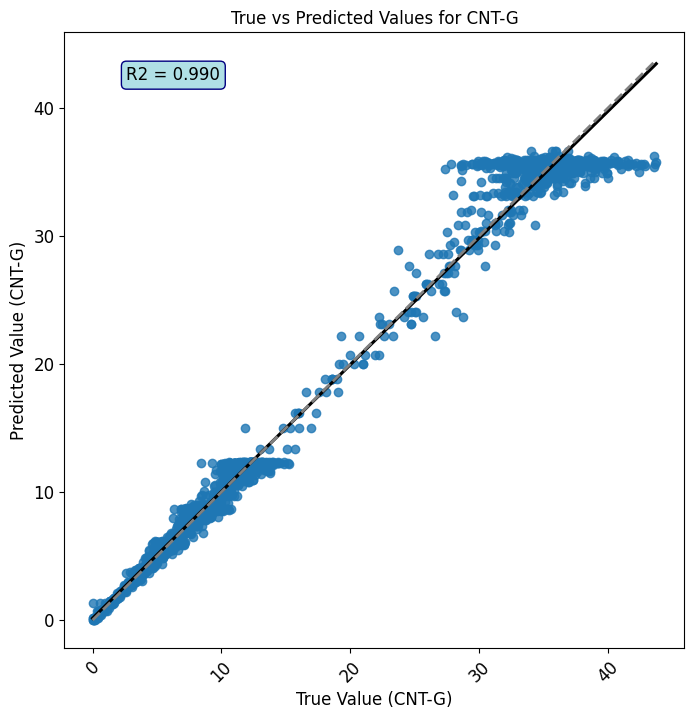

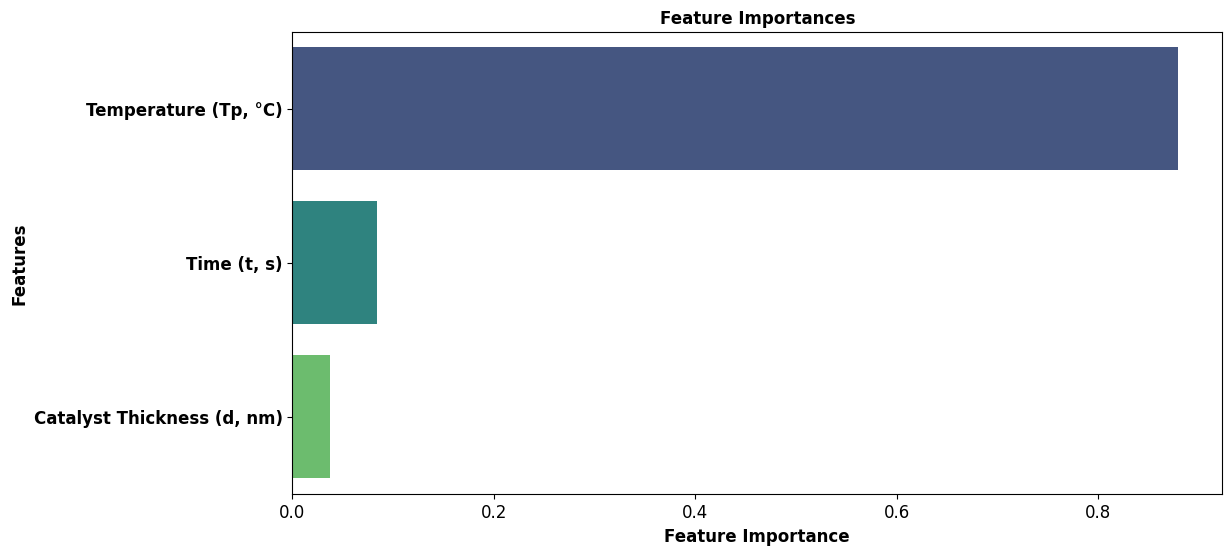

In [15]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [16]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)
model_prediction = ann_model.predict(X_test)

R^2 CNT-G: 0.8258214027516689
MAE CNT-G: 4.161757776610568
MSE CNT-G: 24.05489115016944
RMSE CNT-G: 4.904578590477416


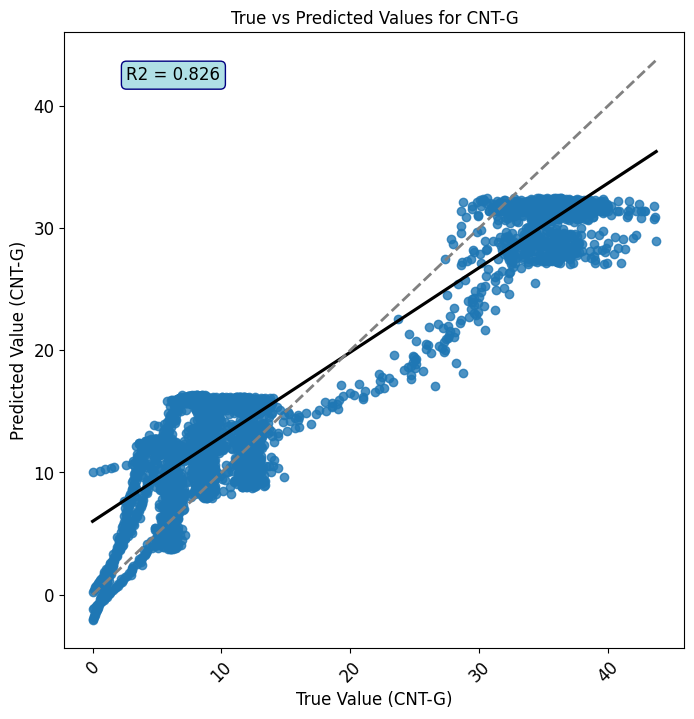

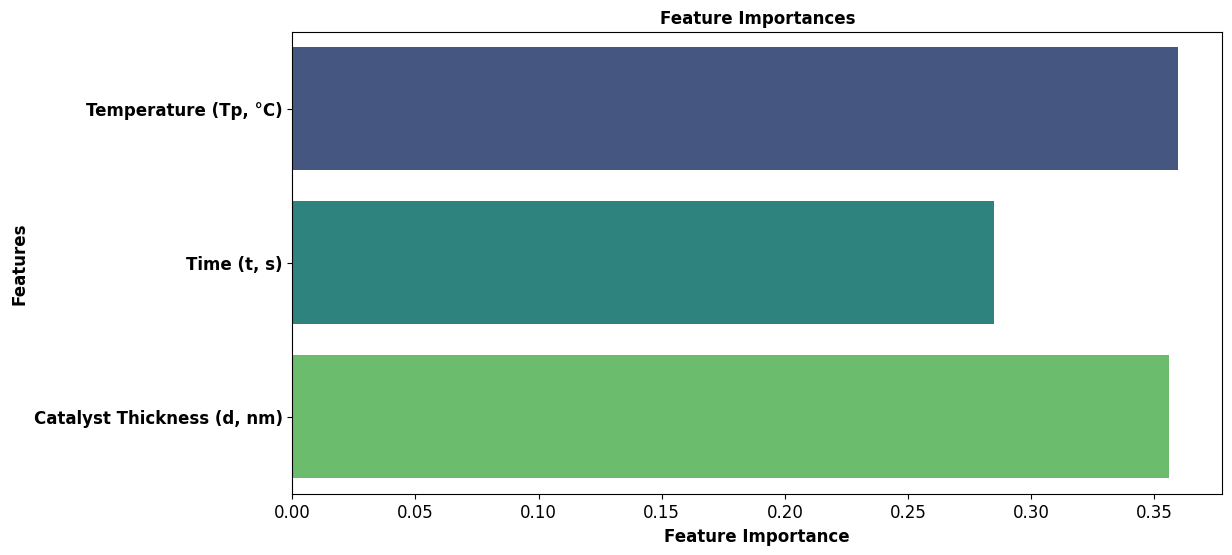

In [17]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Train on only simulated data and test both

In [18]:
test_experiment_numbers = [3, 19, 37, 100, 137, 138, 139]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (9270, 5)


In [19]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  7
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (9270, 3)
Y_test shape: (9270, 1)


In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9816579240945997
MAE CNT-G: 1.0068161415850654
MSE CNT-G: 1.7968255806254787
RMSE CNT-G: 1.3404572281969607


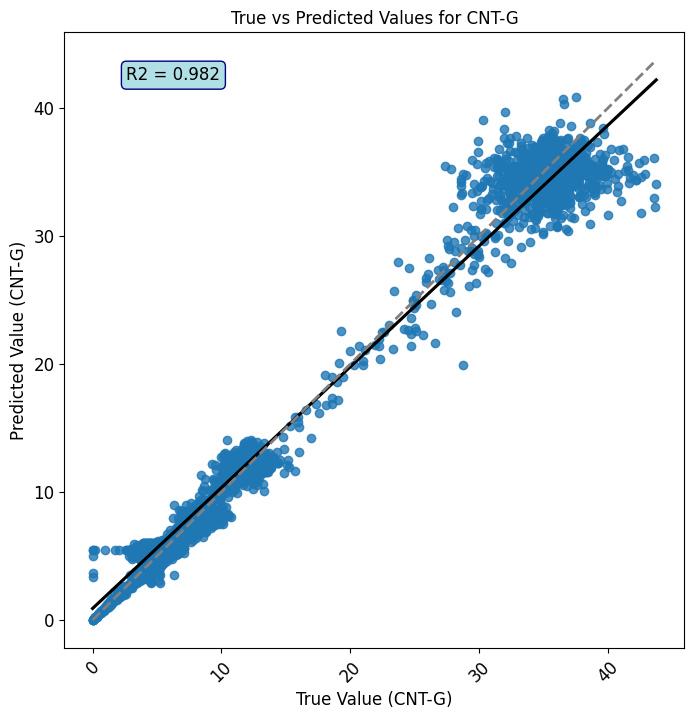

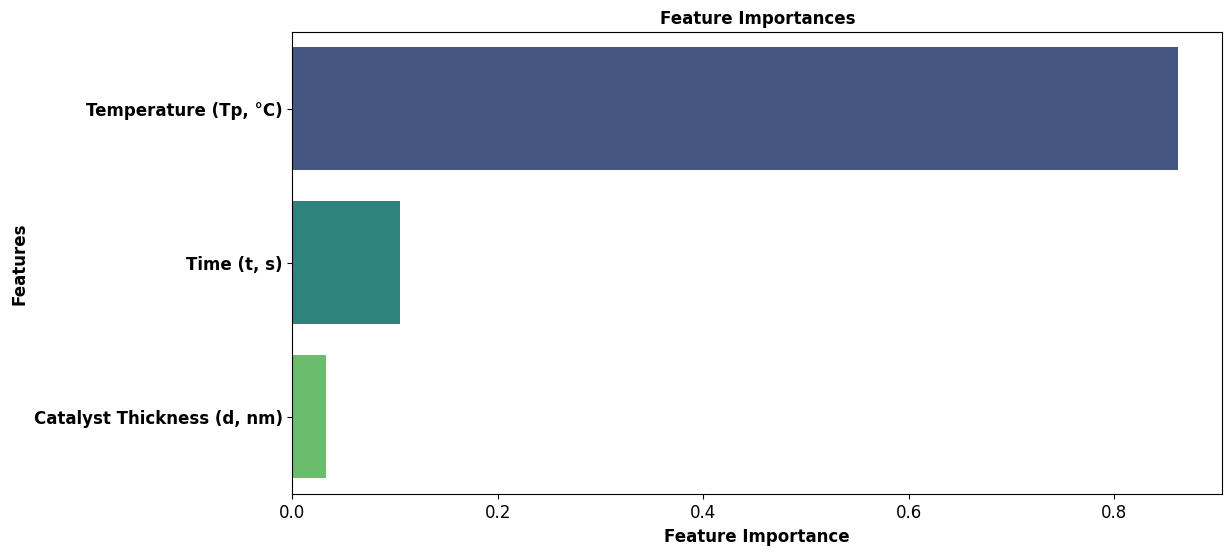

In [21]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [22]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.985904335975647
MAE CNT-G: 0.8682552176741277
MSE CNT-G: 1.3808370675464372
RMSE CNT-G: 1.1750902380440564


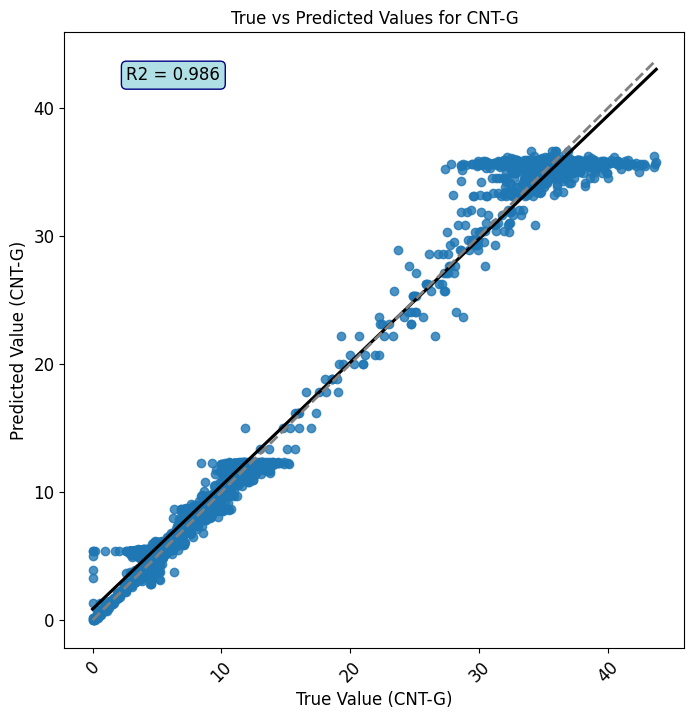

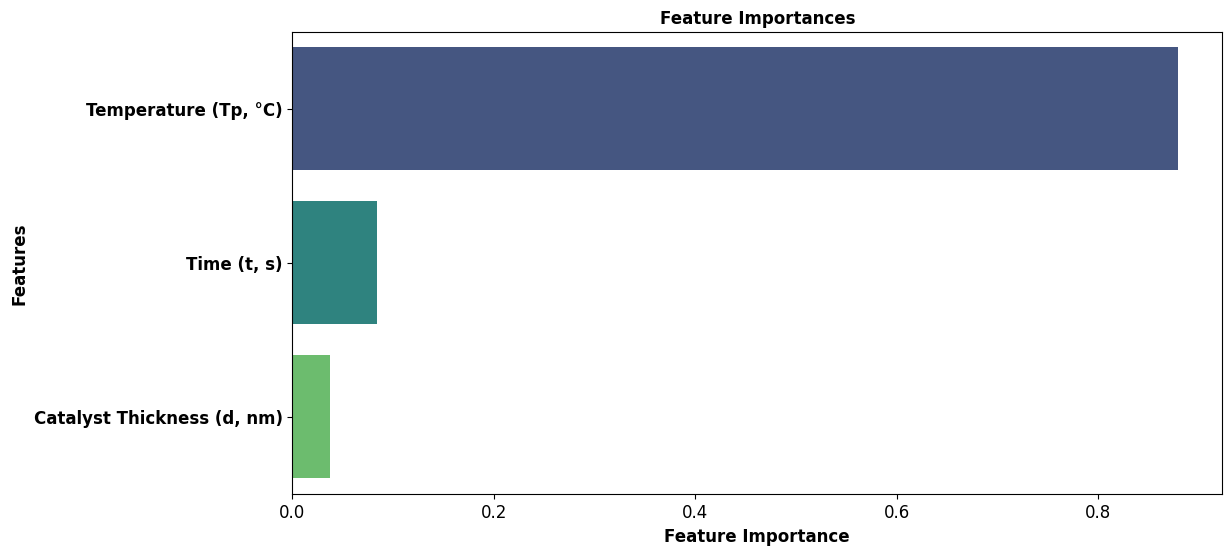

In [23]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [24]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: -13.57880100593806
MAE CNT-G: 15.447751740341195
MSE CNT-G: 1428.167821211858
RMSE CNT-G: 37.79110770024951


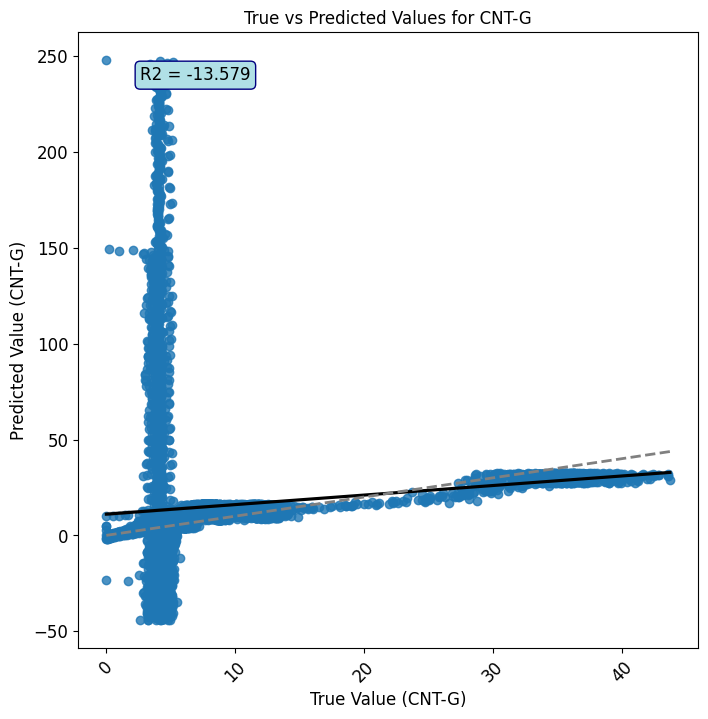

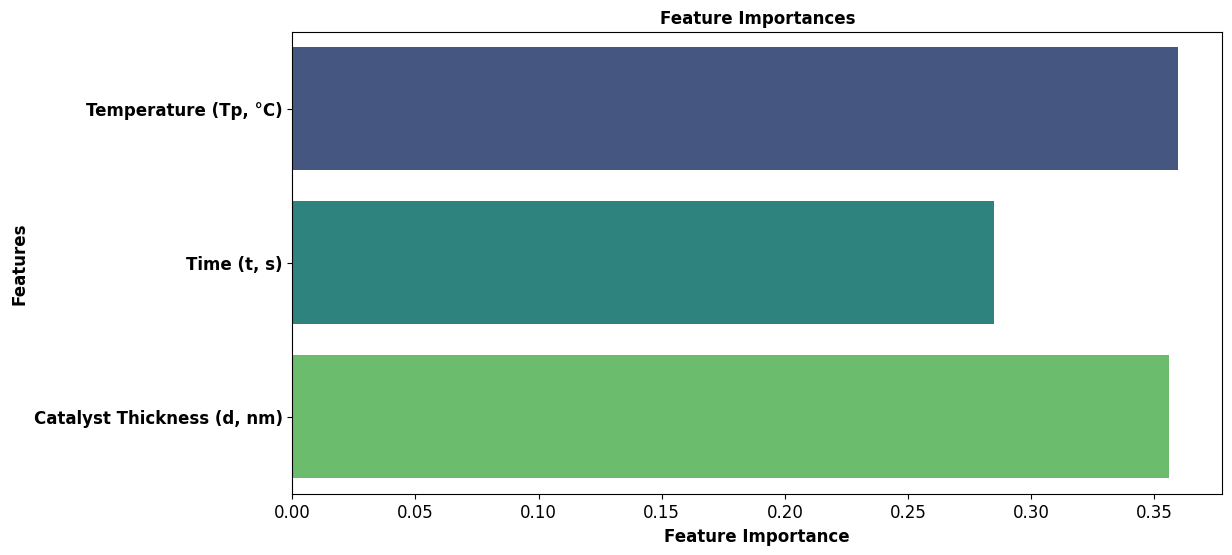

In [25]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Train with both data and test both

In [26]:
test_experiment_numbers = [3, 19, 37, 100, 138]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = full_dataset[~full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (161514, 5)
Test set shape: (6288, 5)


In [27]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  134
Number of Exp for test:  5
X_train shape: (161514, 3)
Y_train shape: (161514, 1)
X_test shape: (6288, 3)
Y_test shape: (6288, 1)


In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9842986940463277
MAE CNT-G: 0.8628569241675439
MSE CNT-G: 1.952379228297187
RMSE CNT-G: 1.3972756450669235


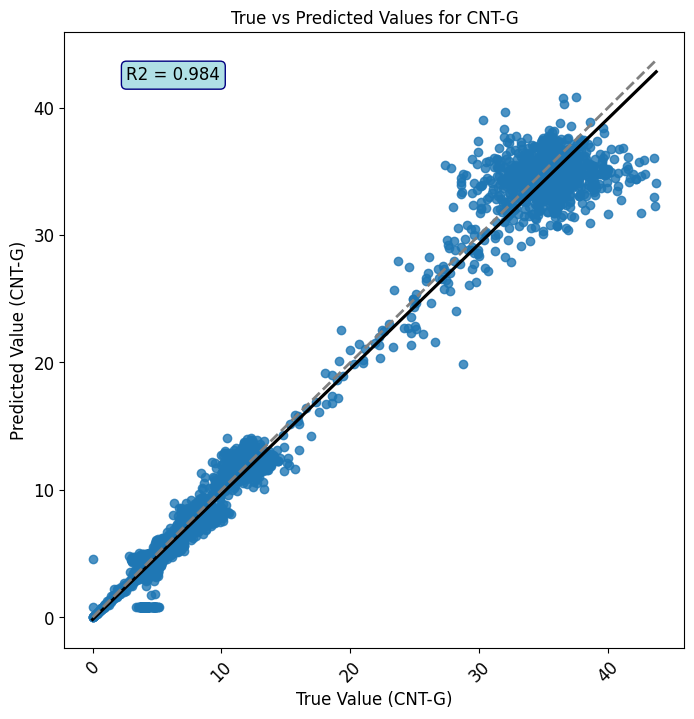

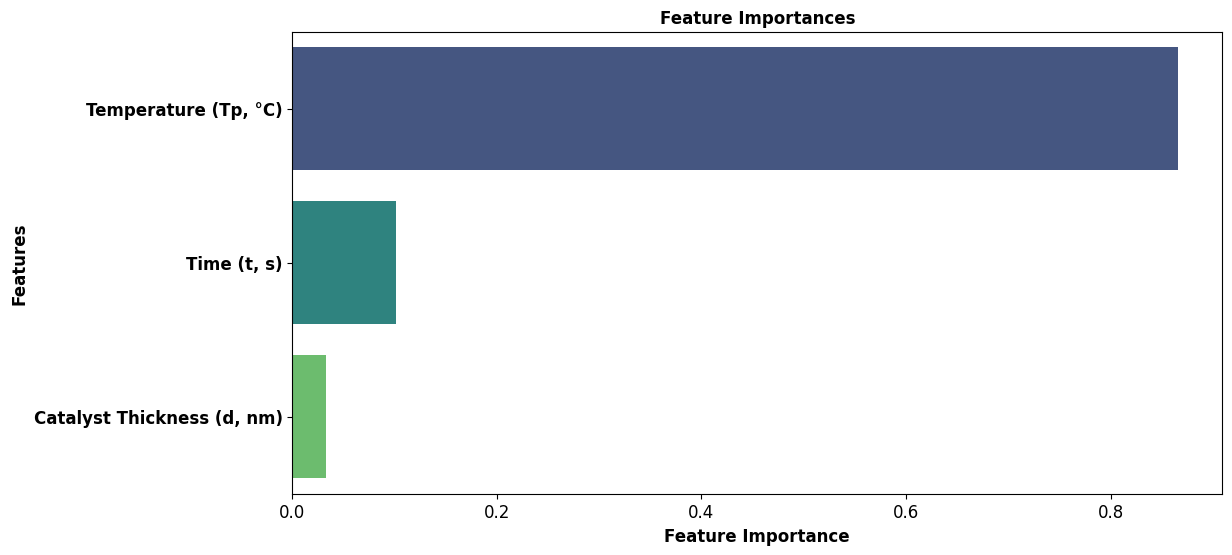

In [29]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [30]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.9911718368530273
MAE CNT-G: 0.594382294597666
MSE CNT-G: 1.0977392133364585
RMSE CNT-G: 1.0477305060636817


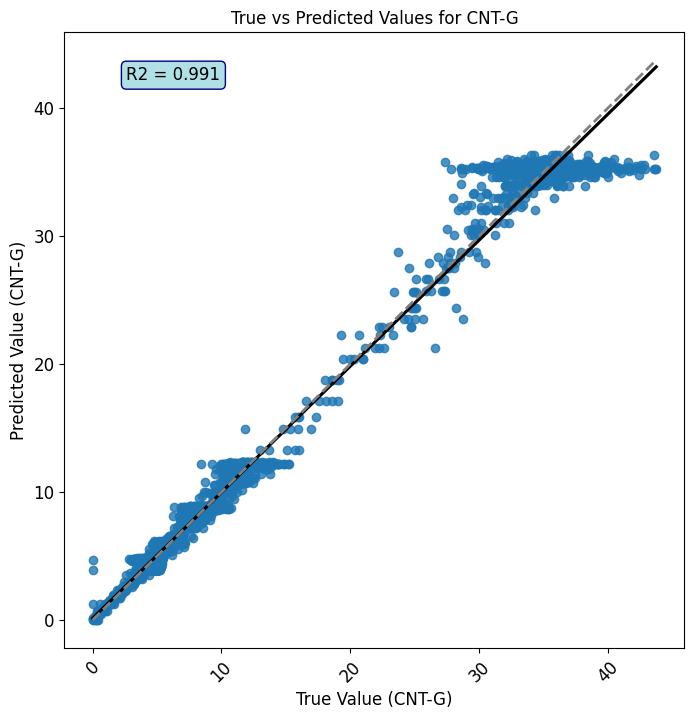

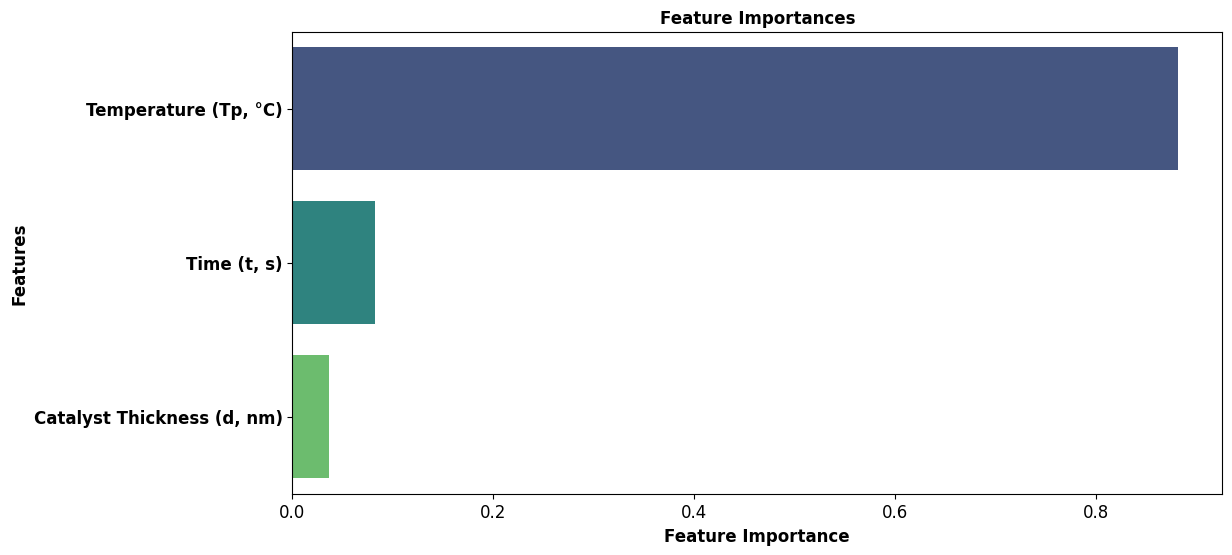

In [31]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [32]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: 0.6619056928923073
MAE CNT-G: 5.337086695948054
MSE CNT-G: 42.04034392745579
RMSE CNT-G: 6.483852552877478


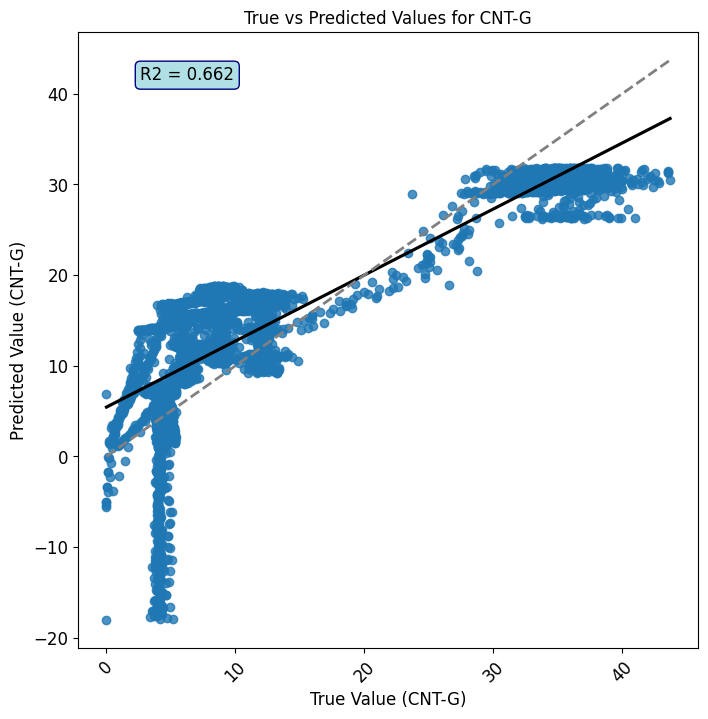

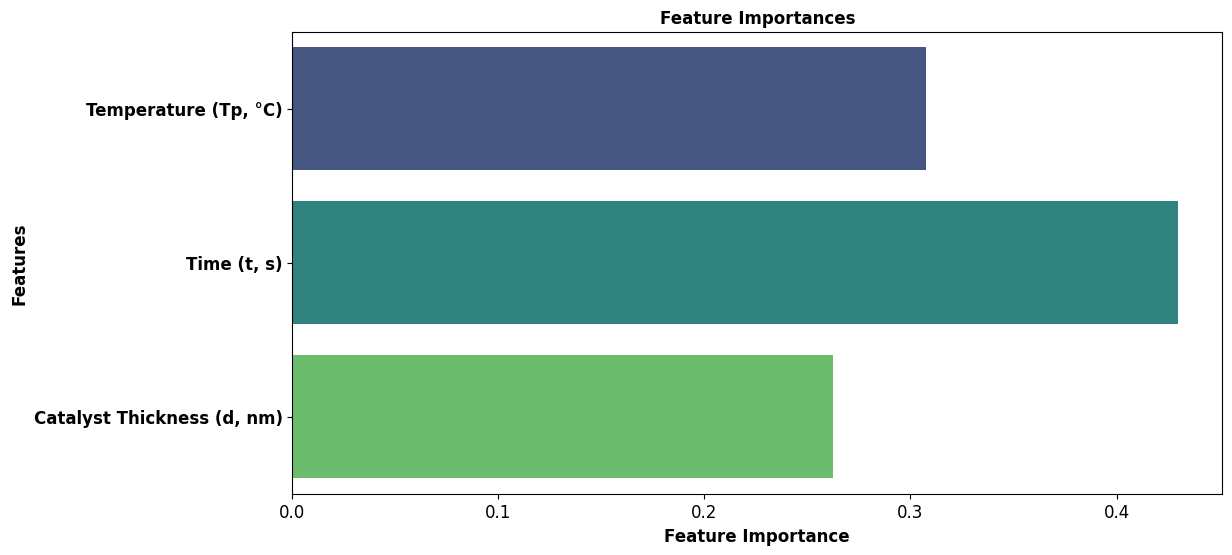

In [33]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

# With Normalization

In [34]:
full_dataset.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,600,0,0.6,0.000000
1,1,600,1,0.6,0.028338
2,1,600,2,0.6,0.076081
3,1,600,3,0.6,0.114440
4,1,600,4,0.6,0.157956


In [35]:
Exp_num = full_dataset['Experiment Number']
full_dataset = full_dataset.drop(columns=['Experiment Number'])
full_dataset, min_values, max_values = normalize_data(full_dataset)
full_dataset['Experiment Number'] = Exp_num

In [36]:
# Reorder the columns to have 'Experiment Number' as the first column
cols = ['Experiment Number'] + [col for col in full_dataset.columns if col != 'Experiment Number']
full_dataset = full_dataset[cols]
full_dataset.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,-1.0,-1.000000,-1.0,-1.000000
1,1,-1.0,-0.999385,-1.0,-0.999168
2,1,-1.0,-0.998769,-1.0,-0.997765
3,1,-1.0,-0.998154,-1.0,-0.996639
4,1,-1.0,-0.997538,-1.0,-0.995361


In [37]:
# Separate the simulated data from the full dataset
simulated_data = full_dataset.loc[simulated_data.index]
original_data_data = full_dataset.loc[original_data.index]
# Display the shape of the separated simulated data to verify
print("Separated simulated data shape:", simulated_data.shape)
print("Separated original data shape:", original_data_data.shape)

Separated simulated data shape: (167802, 5)
Separated original data shape: (8932, 5)


### Train on only simulated data and test simulated

In [38]:
test_experiment_numbers = [3, 19, 37, 100]

# Separate the test set
test_set = simulated_data[simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (162998, 5)
Test set shape: (4804, 5)


In [39]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  135
Number of Exp for test:  4
X_train shape: (162998, 3)
Y_train shape: (162998, 1)
X_test shape: (4804, 3)
Y_test shape: (4804, 1)


In [40]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9841677604494955
MAE CNT-G: 0.026398544617693243
MSE CNT-G: 0.001886260713577445
RMSE CNT-G: 0.0434311030665518


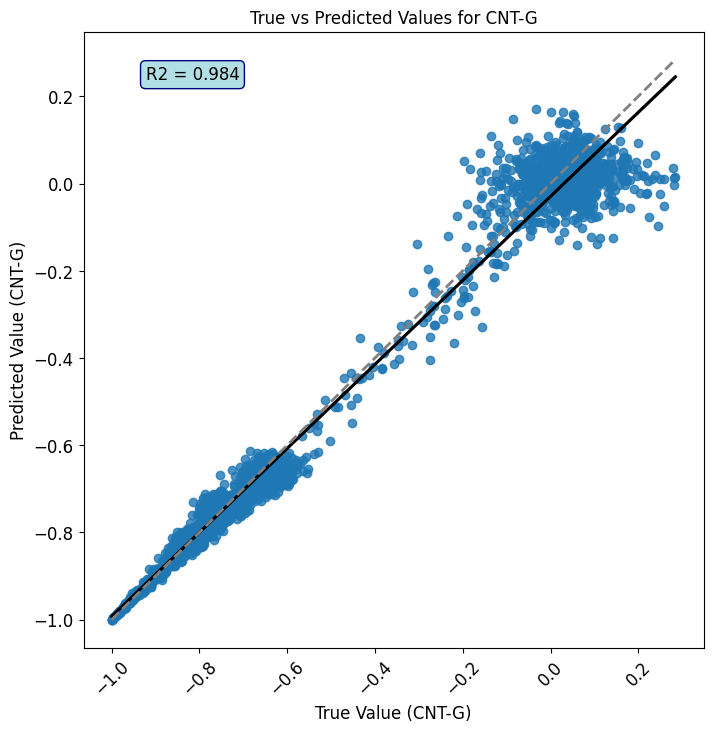

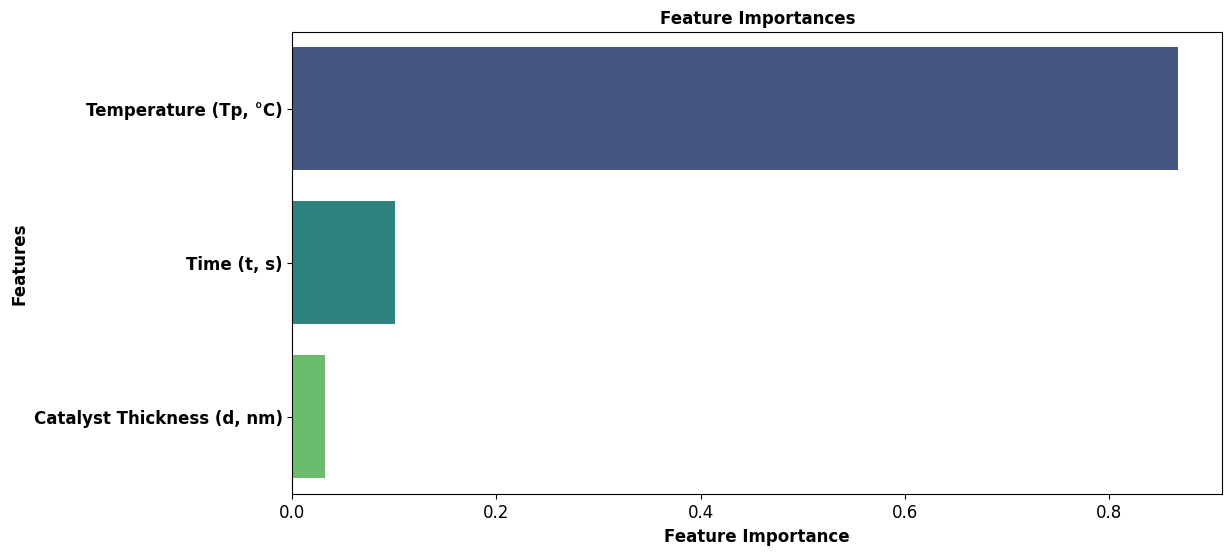

In [41]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [42]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)
model_prediction = xgb_model.predict(X_test)

R^2 CNT-G: 0.9901999831199646
MAE CNT-G: 0.019280966012383702
MSE CNT-G: 0.0011675810222981824
RMSE CNT-G: 0.0341698847276104


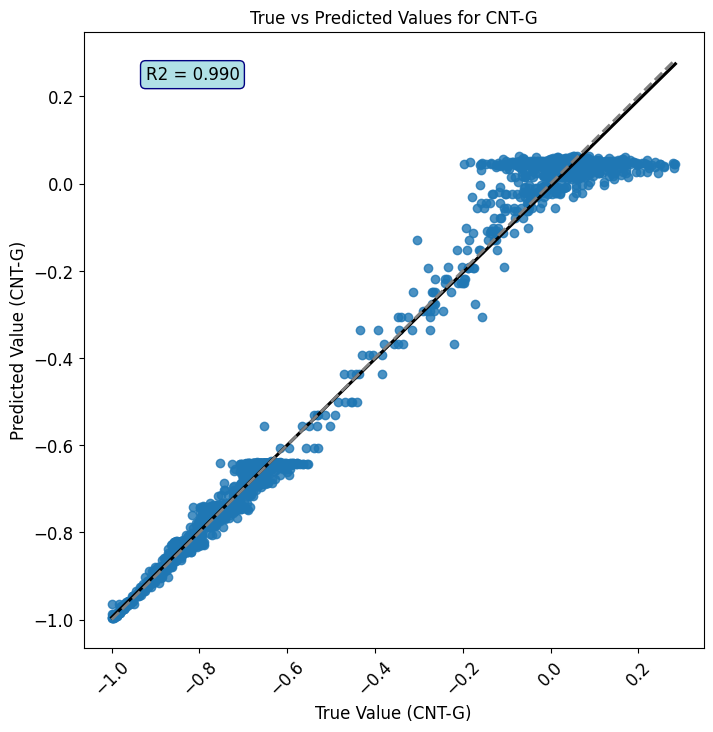

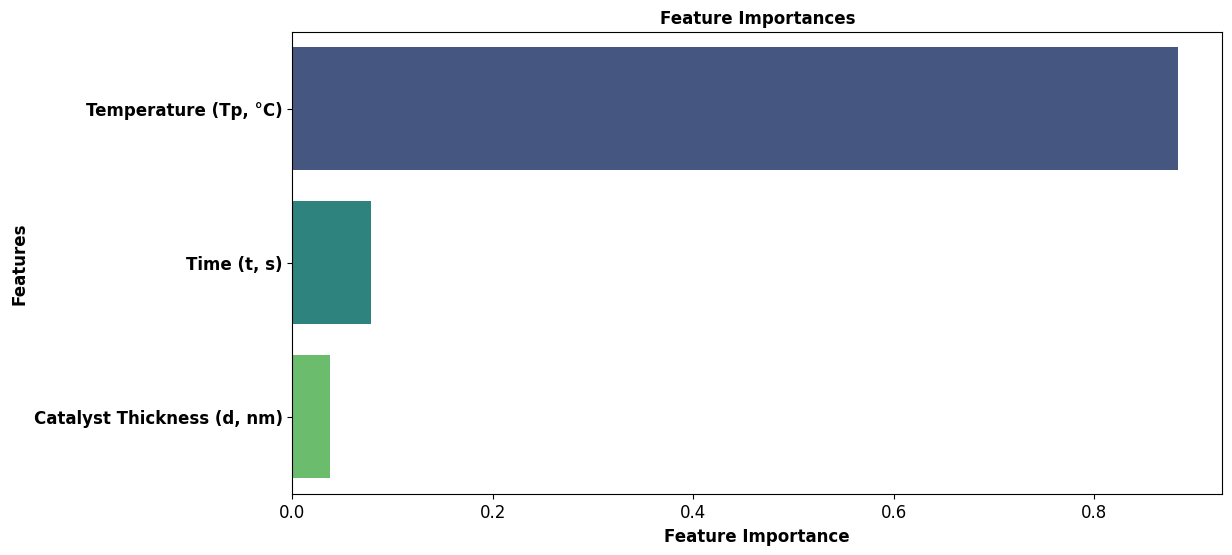

In [43]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [44]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)
model_prediction = ann_model.predict(X_test)

R^2 CNT-G: 0.989709015638789
MAE CNT-G: 0.021286649297292726
MSE CNT-G: 0.0012260728776033315
RMSE CNT-G: 0.035015323468494924


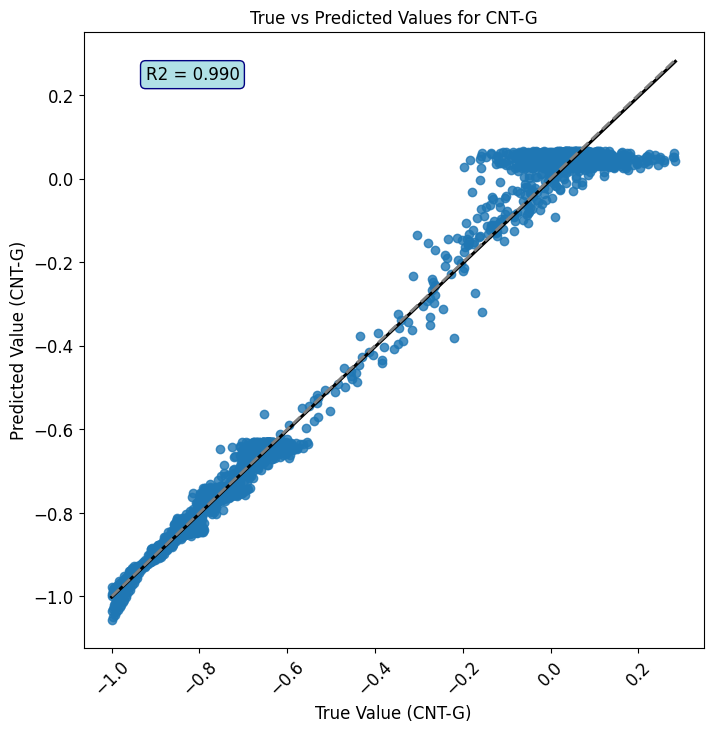

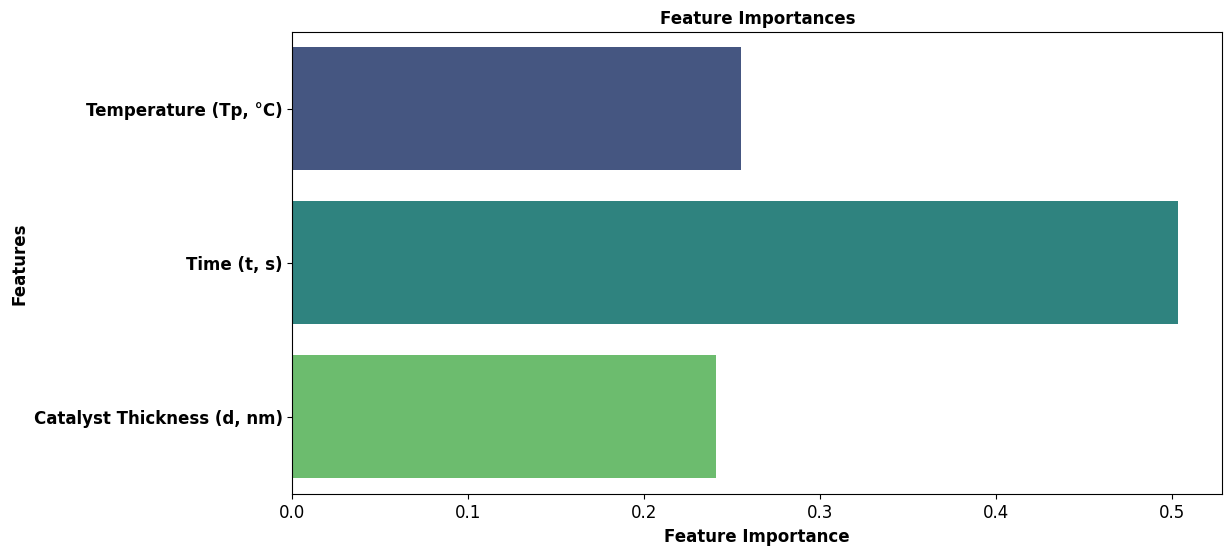

In [45]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### Train on only simulated data and test both

In [46]:
test_experiment_numbers = [3, 19, 37, 100, 137, 138, 139]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (9270, 5)


In [47]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  7
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (9270, 3)
Y_test shape: (9270, 1)


In [48]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9807096566293041
MAE CNT-G: 0.029903239121114124
MSE CNT-G: 0.0016302272691579623
RMSE CNT-G: 0.04037607297841089


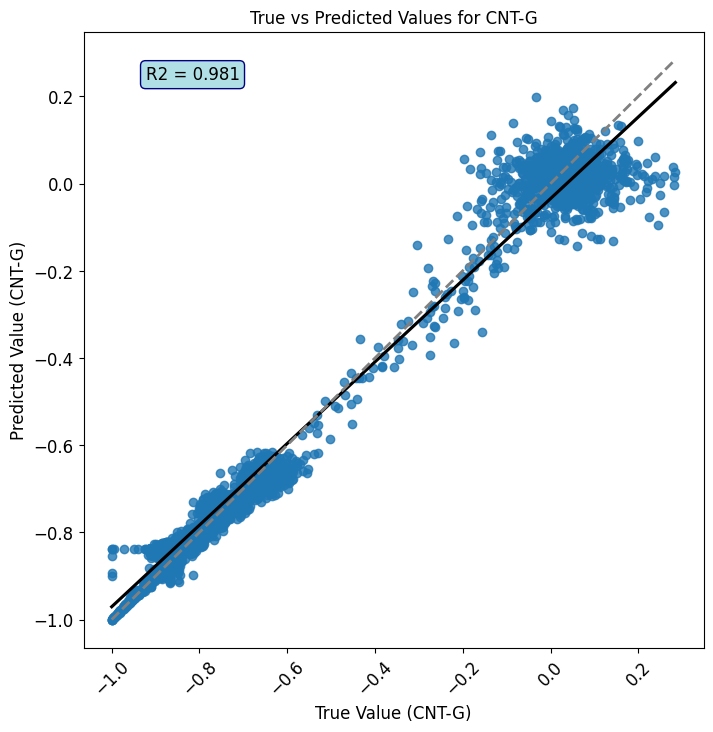

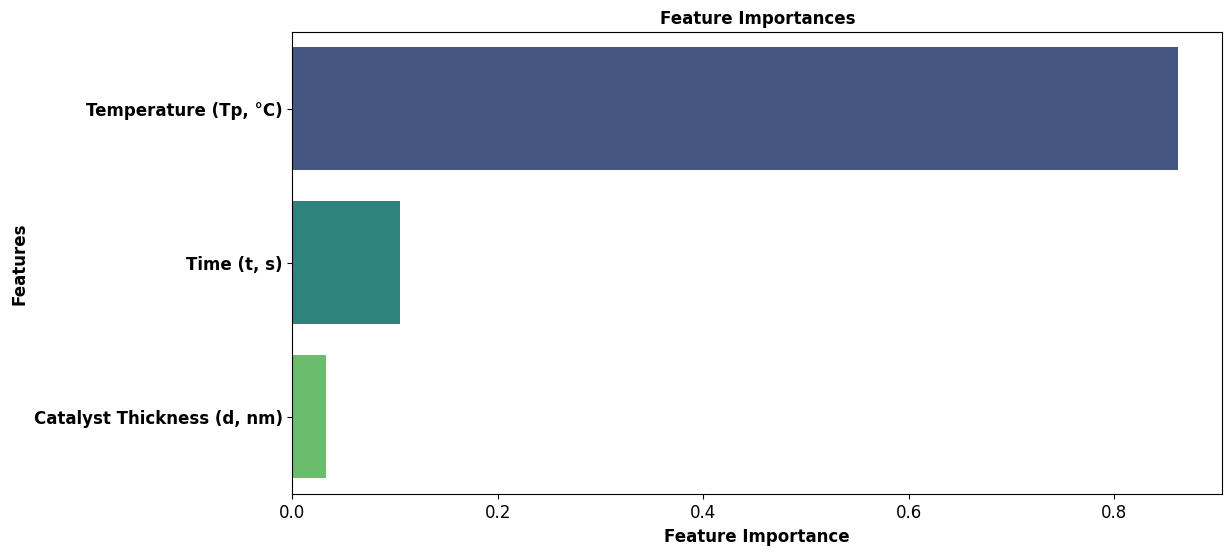

In [49]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [50]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.985904335975647
MAE CNT-G: 0.025502565899241887
MSE CNT-G: 0.0011912236008498672
RMSE CNT-G: 0.03451410727296691


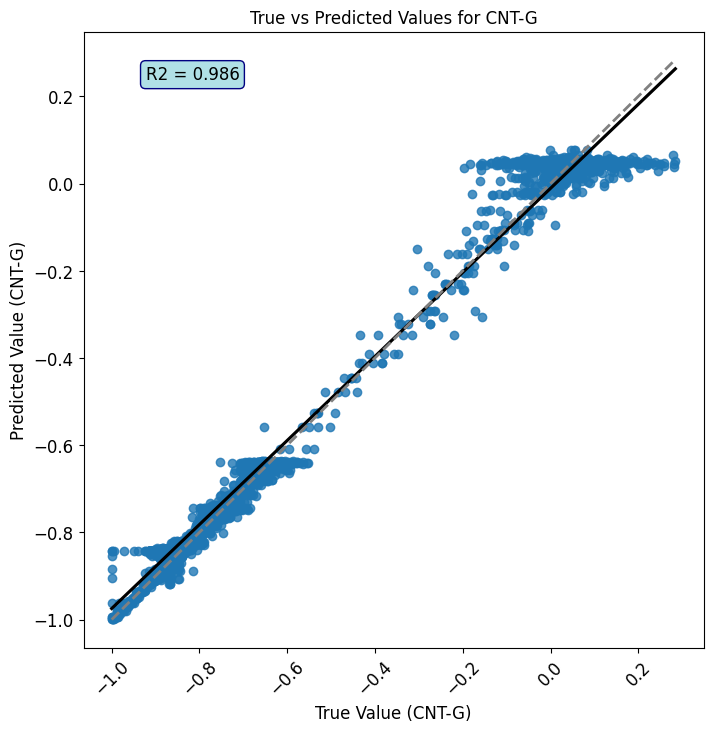

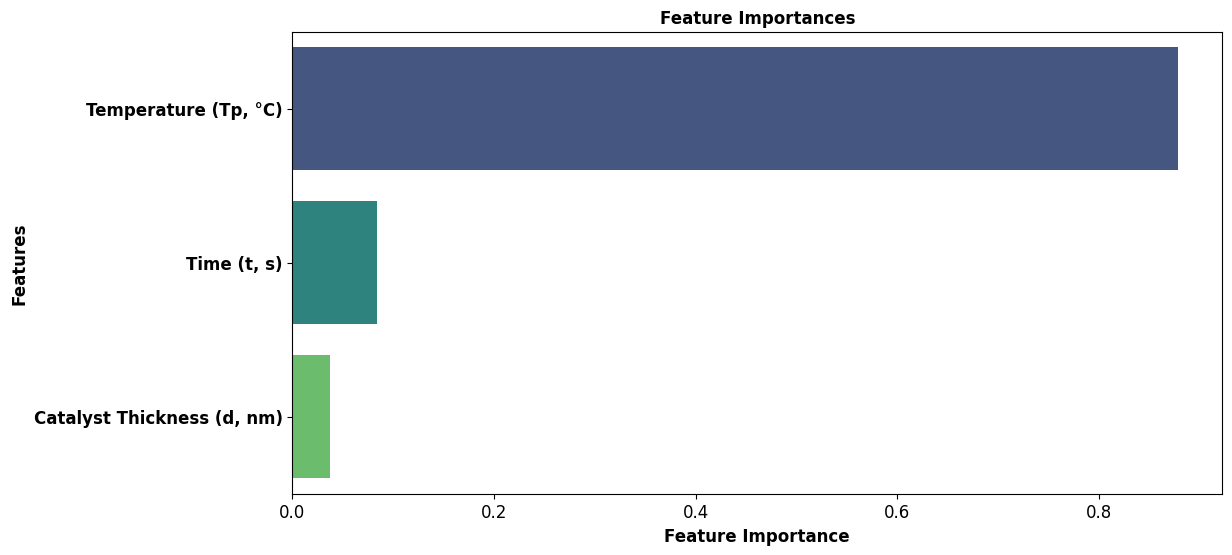

In [51]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [52]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: -8.189022614104632
MAE CNT-G: 0.35864340274607276
MSE CNT-G: 0.7765644682706424
RMSE CNT-G: 0.8812289533774083


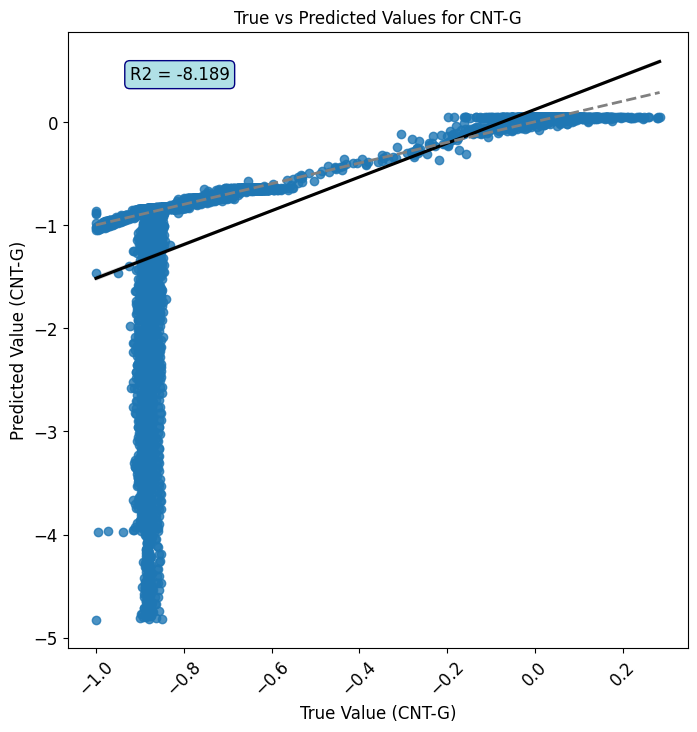

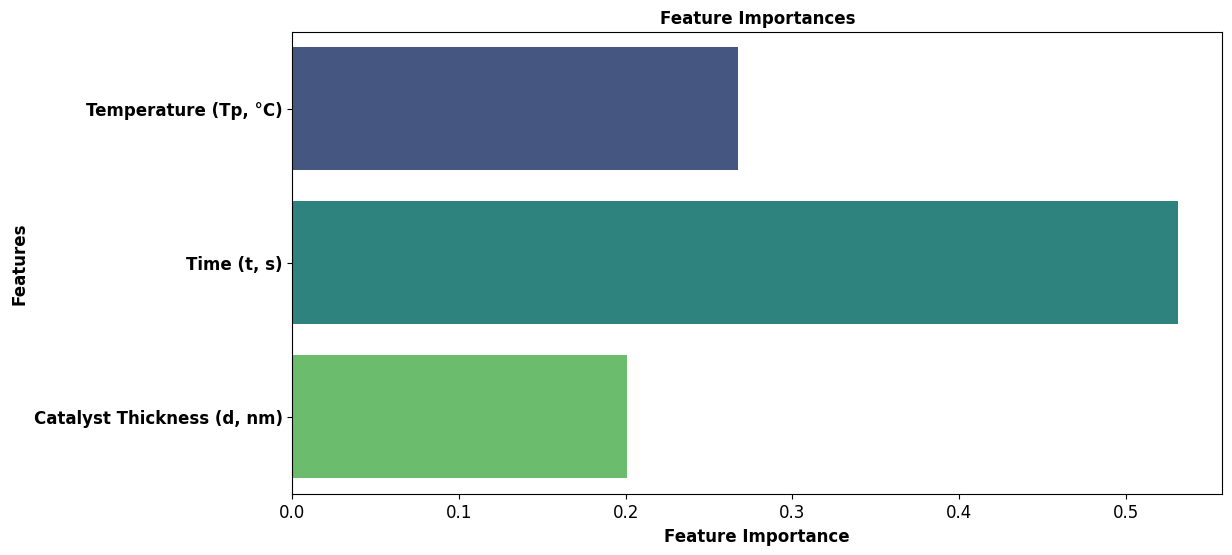

In [53]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### $\color{red}{\text{Train with both data and test both}}$


In [54]:
test_experiment_numbers = [3, 19, 37, 100, 138]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]
test_set_exp = full_dataset[full_dataset['Experiment Number'].isin([138])]
test_set_sim = full_dataset[full_dataset['Experiment Number'].isin([3, 19, 37, 100])]

# Separate the training set
training_set = full_dataset[~full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)
print("Test set EXP shape:", test_set_exp.shape)
print("Test set SIM shape:", test_set_sim.shape)

Training set shape: (161514, 5)
Test set shape: (6288, 5)
Test set EXP shape: (1484, 5)
Test set SIM shape: (4804, 5)


In [55]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

print("-----------------------")
Y_test_exp = test_set_exp[target]
X_test_exp = test_set_exp.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test_exp['Experiment Number'].unique()))
X_test_exp = X_test_exp.drop("Experiment Number", axis=1)
print("X_test EXP shape:", X_test_exp.shape)
print("Y_test EXP shape:", Y_test_exp.shape)

print("-----------------------")
Y_test_sim = test_set_sim[target]
X_test_sim = test_set_sim.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test_sim['Experiment Number'].unique()))
X_test_sim = X_test_sim.drop("Experiment Number", axis=1)
print("X_test EXP shape:", X_test_sim.shape)
print("Y_test EXP shape:", Y_test_sim.shape)

Number of Exp for train:  134
Number of Exp for test:  5
X_train shape: (161514, 3)
Y_train shape: (161514, 1)
X_test shape: (6288, 3)
Y_test shape: (6288, 1)
-----------------------
Number of Exp for test:  1
X_test EXP shape: (1484, 3)
Y_test EXP shape: (1484, 1)
-----------------------
Number of Exp for test:  4
X_test EXP shape: (4804, 3)
Y_test EXP shape: (4804, 1)


In [56]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9832030299837415
MAE CNT-G: 0.025829107528171528
MSE CNT-G: 0.001801814629966435
RMSE CNT-G: 0.04244778710329238


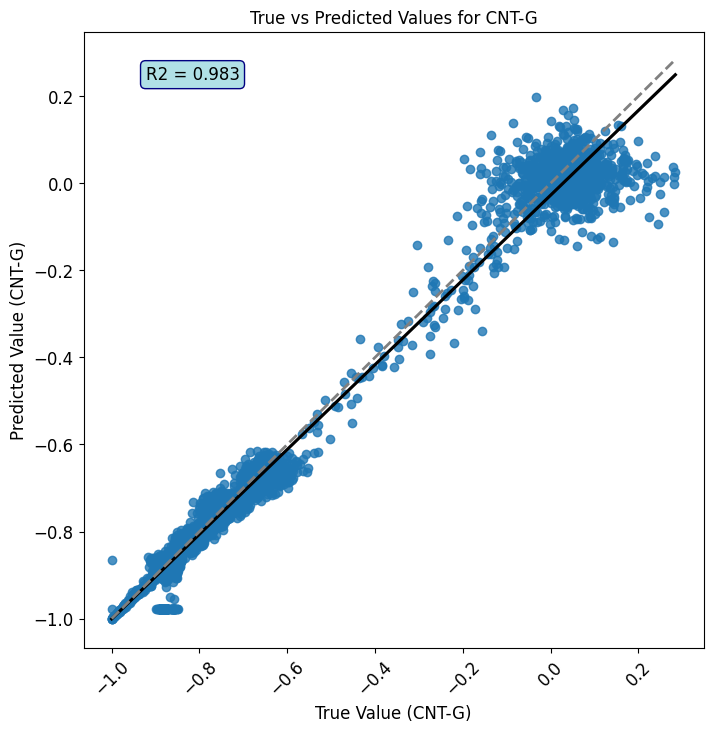

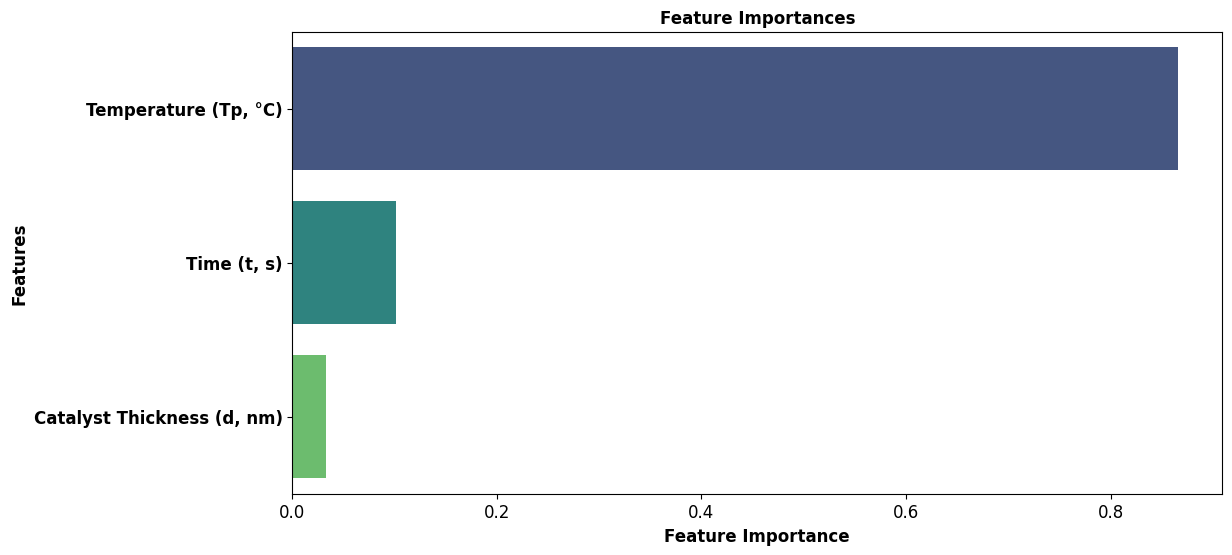

In [57]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

### Test on EXP data

In [58]:
# model_prediction = rf_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(rf_model,features)

### Test on SIM data

R^2 CNT-G: 0.9842141290365893
MAE CNT-G: 0.026416166825186035
MSE CNT-G: 0.0018807363375787072
RMSE CNT-G: 0.043367457126037574


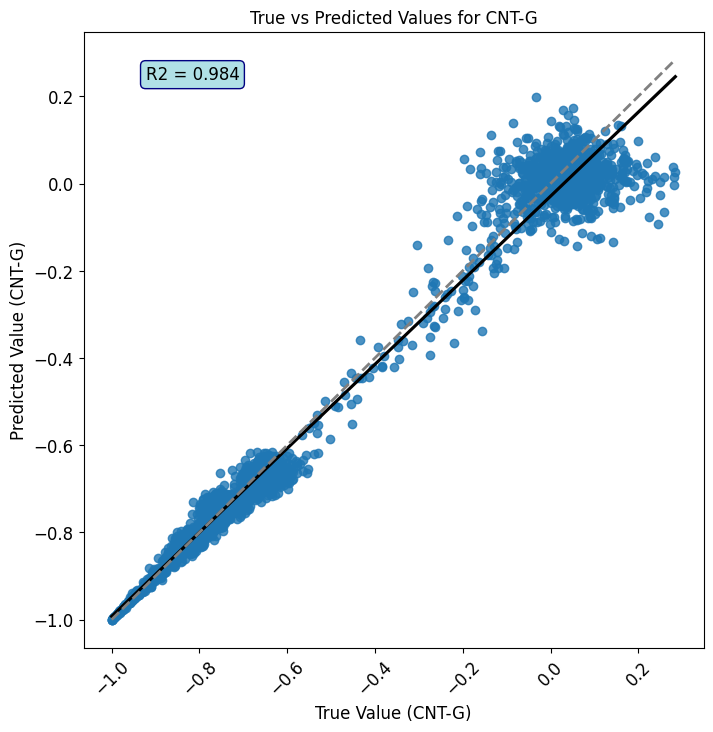

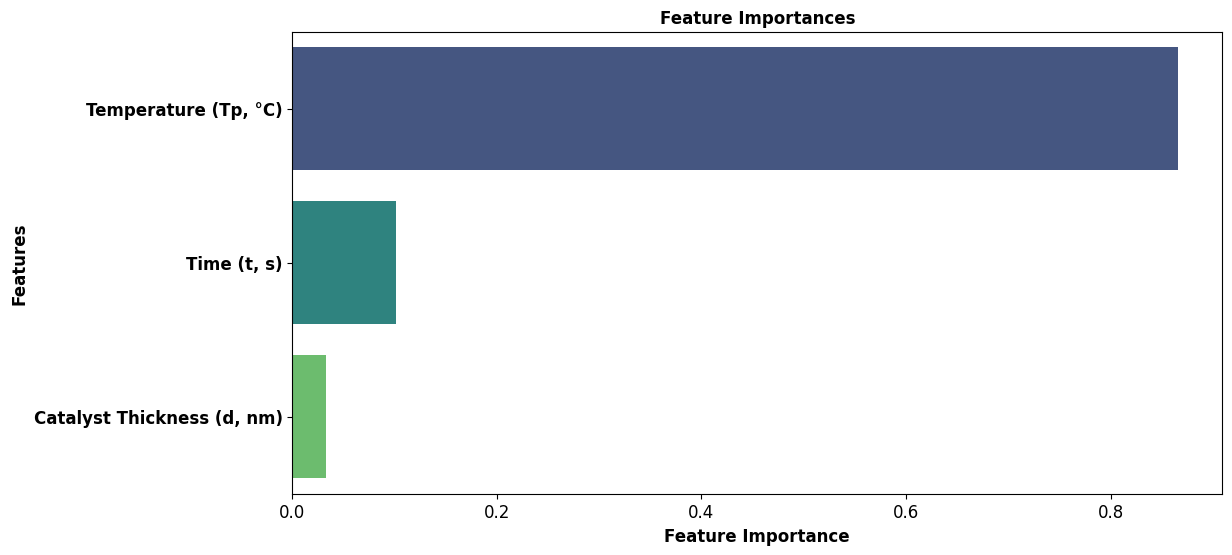

In [59]:
model_prediction = rf_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(rf_model,features)

In [60]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.9911718368530273
MAE CNT-G: 0.017457865125493154
MSE CNT-G: 0.0009469992761454045
RMSE CNT-G: 0.030773353345799098


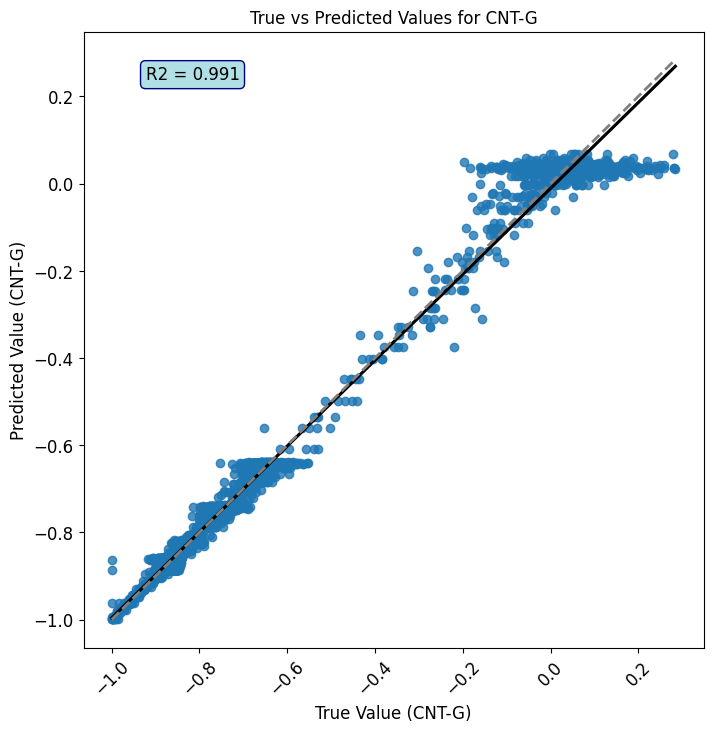

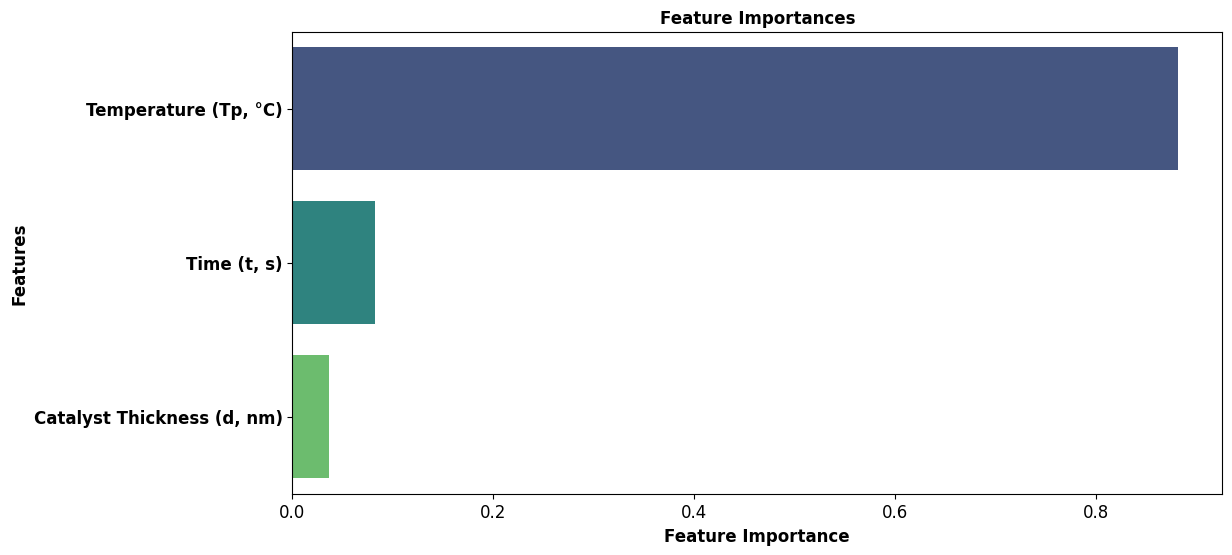

In [61]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

### Test on EXP data

In [62]:
# model_prediction = xgb_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(xgb_model,features)

### Test on SIM data

R^2 CNT-G: 0.9901774525642395
MAE CNT-G: 0.019421871668541413
MSE CNT-G: 0.0011702618845397682
RMSE CNT-G: 0.034209090671044856


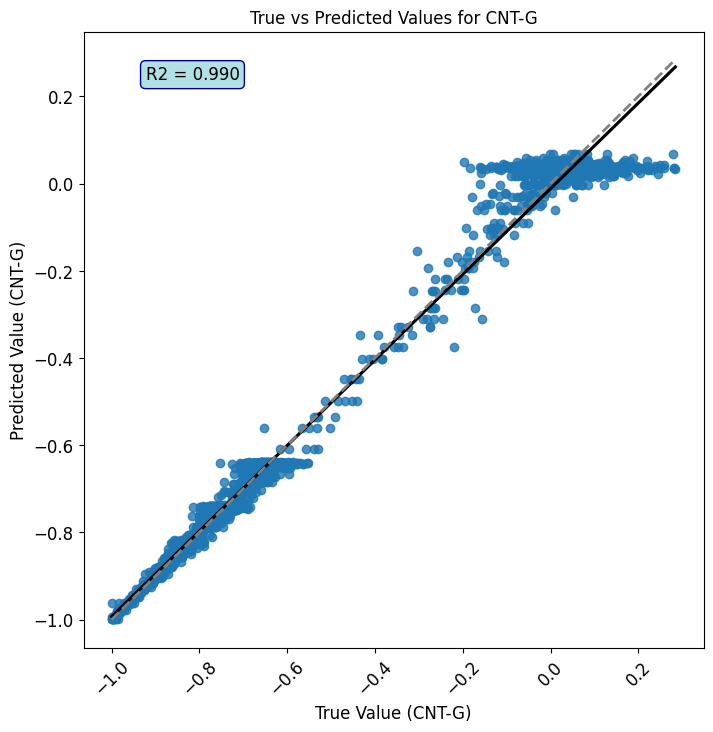

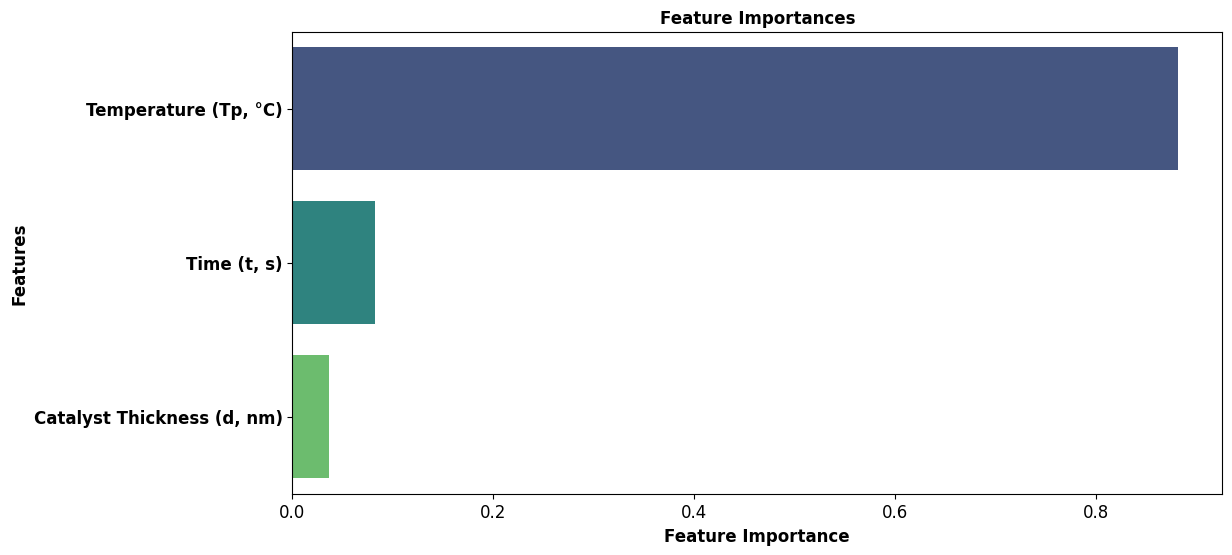

In [63]:
model_prediction = xgb_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(xgb_model,features)

In [64]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: 0.9861405719182775
MAE CNT-G: 0.022427187521993373
MSE CNT-G: 0.0014867038672119759
RMSE CNT-G: 0.038557799045225286


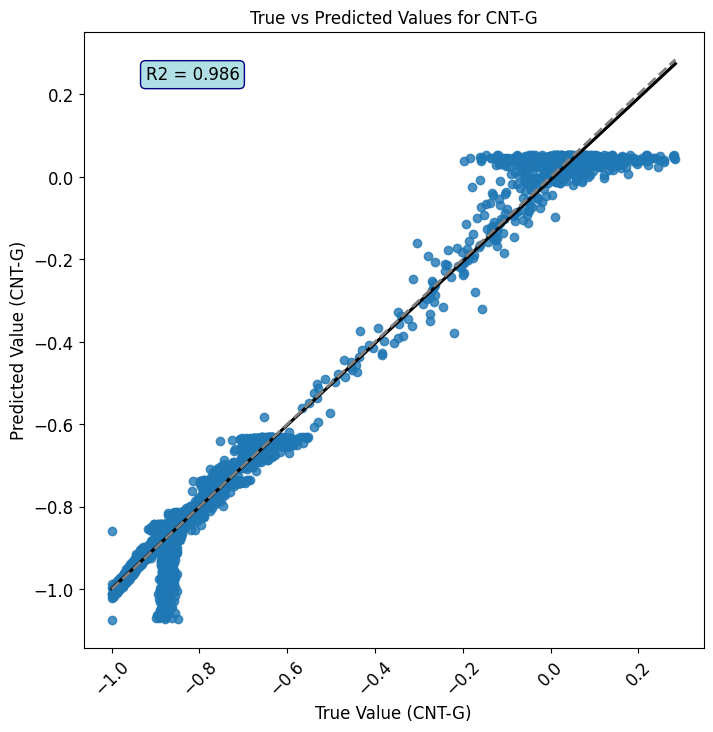

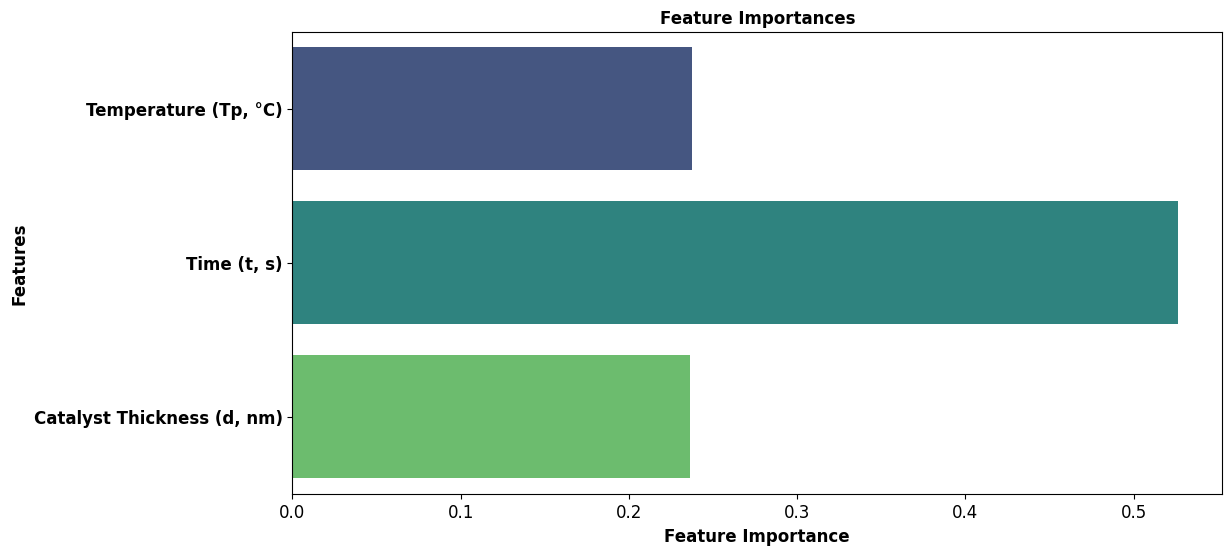

In [65]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### Test on EXP data

In [66]:
# model_prediction = ann_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(ann_model,features, model_name="ann")

### Test on SIM data

R^2 CNT-G: 0.9900360046410426
MAE CNT-G: 0.020610896379375993
MSE CNT-G: 0.0011871152489775572
RMSE CNT-G: 0.034454538873384406


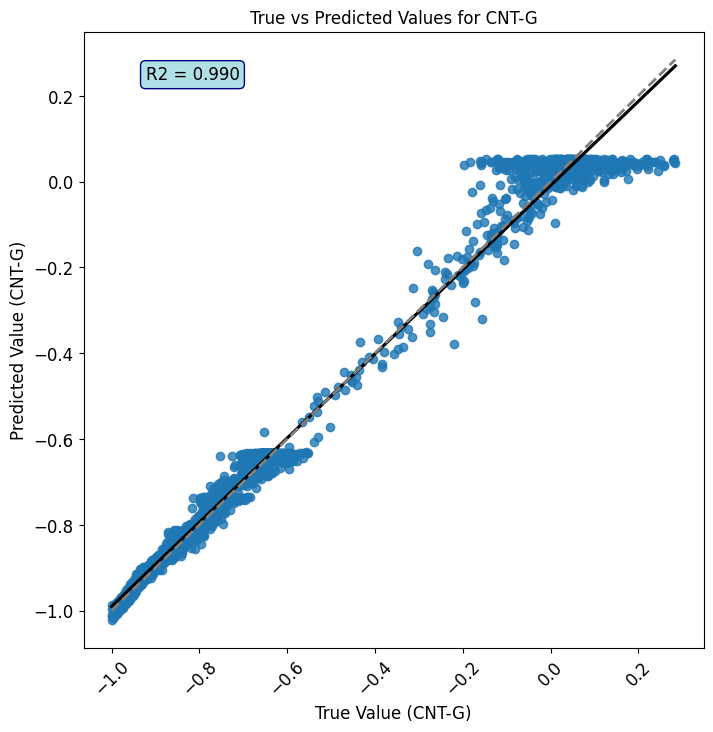

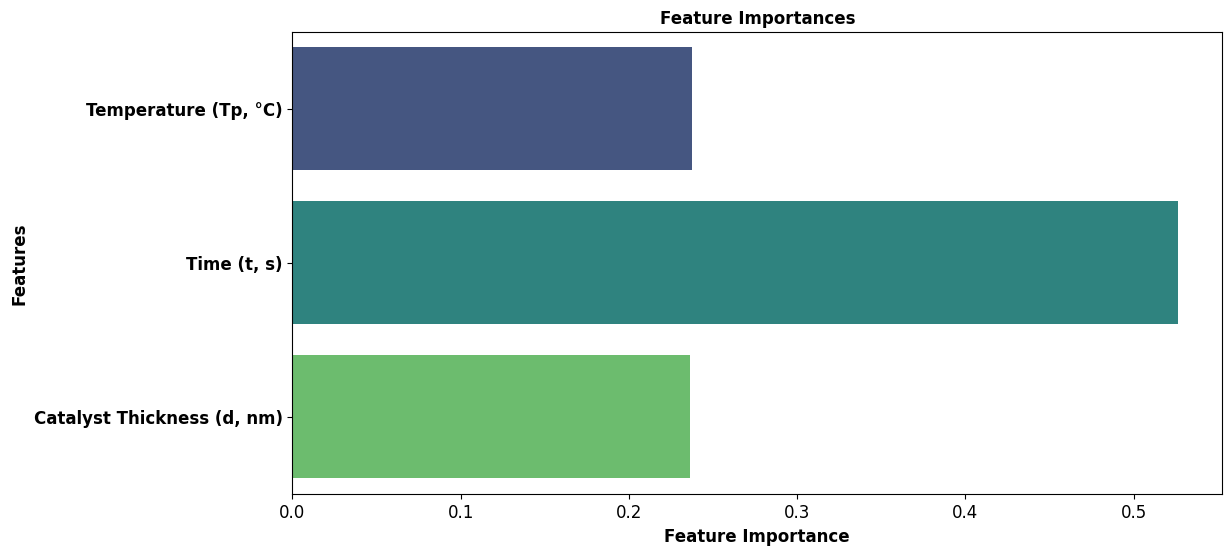

In [67]:
model_prediction = ann_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Necessary Graph

In [68]:
results_col = ['Model', 'R2- Simulated Test', 'R2- Simulated & Experimental Validation']
models_list = ['Random Forest', 'XGBoost', 'ANN']
r2_sim_list = [0.984, 0.990, 0.990]
r2_exp_sim_list = [0.983, 0.991, 0.986]
rmse_sim_list = [0.0433, 0.0342, 0.0344]
rmse_exp_sim_list = [0.0424, 0.0307, 0.0385]
mae_sim_list = [0.0264, 0.0194, 0.0206]
mae_exp_sim_list = [0.0258, 0.0174, 0.0224]

'5.10.4'

(6288,)


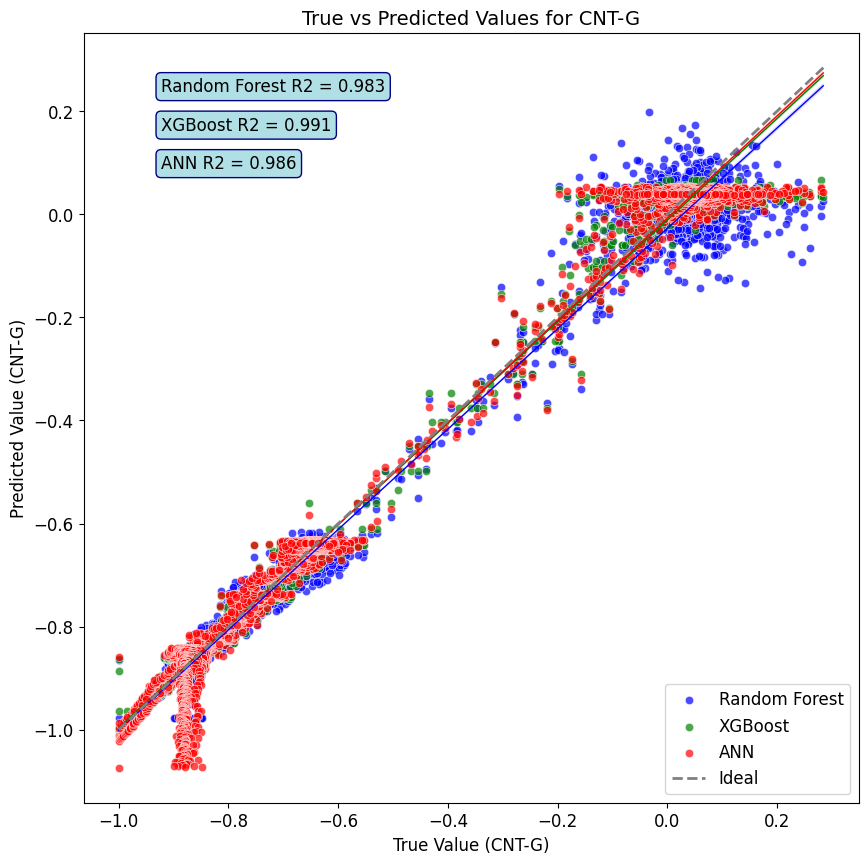

In [69]:
true_pred_plot_multiple(
    Y_test,
    [rf_model.predict(X_test).ravel(), xgb_model.predict(X_test).ravel(), ann_model.predict(X_test).ravel()],
    ["Random Forest", "XGBoost", "ANN"],
    "CNT-G"
)

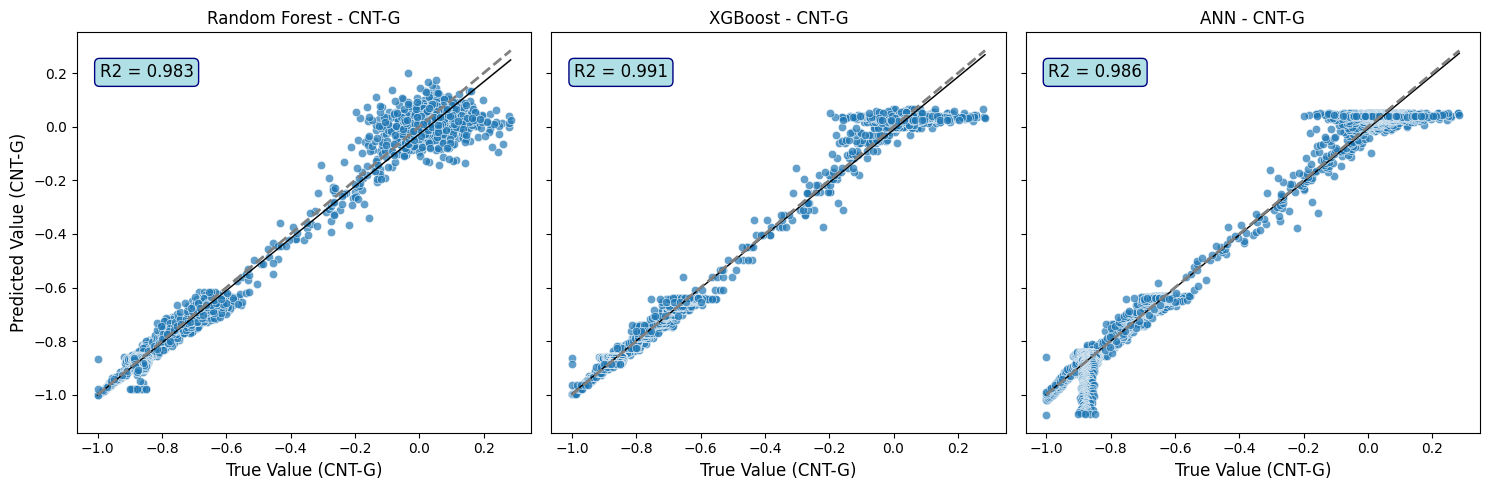

In [70]:
true_pred_plot_subplots(
    Y_test,
    [rf_model.predict(X_test), xgb_model.predict(X_test), ann_model.predict(X_test)],
    ["Random Forest", "XGBoost", "ANN"],
    "CNT-G"
)


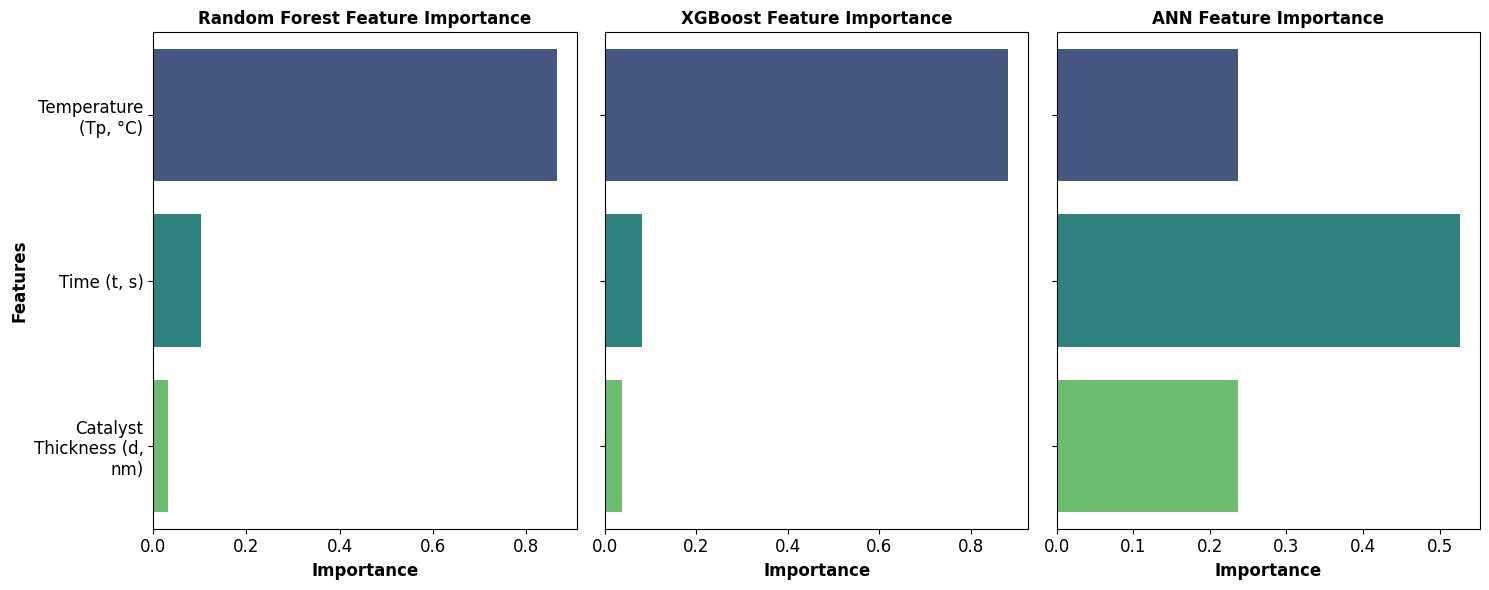

In [71]:
fea_side_by_side(
    models=[rf_model, xgb_model, ann_model],
    features=features,
    model_names=["Random Forest", "XGBoost", "ANN"]
)

## Generation experiment description

In [72]:
temperature_range = [600, 625, 650,675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
thickness_range = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

In [73]:
min_temp = min(temperature_range)
max_temp = max(temperature_range)
temp = [int(temp) for temp in np.linspace(min_temp, max_temp, 100) if temp not in temperature_range]

min_thikness = min(thickness_range)
max_thikness = max(thickness_range)
thikness = [round(thikness,3) for thikness in np.linspace(min_thikness, max_thikness, 100) if temp not in thickness_range]
thikness[0] = 0.61

print(temp)
print(thikness)

[604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 701, 705, 709, 713, 717, 721, 725, 729, 733, 737, 741, 745, 749, 753, 757, 761, 765, 769, 773, 777, 781, 785, 789, 793, 797, 802, 806, 810, 814, 818, 822, 826, 830, 834, 838, 842, 846, 850, 854, 858, 862, 866, 870, 874, 878, 882, 886, 890, 894, 898, 903, 907, 911, 915, 919, 923, 927, 931, 935, 939, 943, 947, 951, 955, 959, 963, 967, 971, 975, 979, 983, 987, 991, 995]
[0.61, 0.614, 0.628, 0.642, 0.657, 0.671, 0.685, 0.699, 0.713, 0.727, 0.741, 0.756, 0.77, 0.784, 0.798, 0.812, 0.826, 0.84, 0.855, 0.869, 0.883, 0.897, 0.911, 0.925, 0.939, 0.954, 0.968, 0.982, 0.996, 1.01, 1.024, 1.038, 1.053, 1.067, 1.081, 1.095, 1.109, 1.123, 1.137, 1.152, 1.166, 1.18, 1.194, 1.208, 1.222, 1.236, 1.251, 1.265, 1.279, 1.293, 1.307, 1.321, 1.335, 1.349, 1.364, 1.378, 1.392, 1.406, 1.42, 1.434, 1.448, 1.463, 1.477, 1.491, 1.505, 1.519, 1.533, 1.547, 1.562, 1.576, 1.59, 1.604, 1.618, 1.63

In [74]:
full_dataset.columns

Index(['Experiment Number', 'Temperature (Tp, °C)', 'Time (t, s)',
       'Catalyst Thickness (d, nm)', 'CNT-G (micrometers/s)'],
      dtype='object')

In [75]:
# Create a dataframe with the specified columns
temperature = temp[0]
catalyst_thickness = thikness[0]
time_values = np.arange(0, 1201, 1)  # Time values from 0 to 1200

# Create the dataframe
df_new = pd.DataFrame({
    'Temperature (Tp, °C)': [temperature] * len(time_values),
    'Time (t, s)': time_values,
    'Catalyst Thickness (d, nm)': [catalyst_thickness] * len(time_values)
})
df_new['CNT-G (micrometers/s)'] = rf_model.predict(df_new)
df_new['Experiment Number'] = 1
df_new = df_new[full_dataset.columns]
df_new.head()

,Experiment Number,"Temperature (Tp, °C)","Time (t, s)","Catalyst Thickness (d, nm)",CNT-G (micrometers/s)
0,1,604,0,0.61,0.231398
1,1,604,1,0.61,0.231398
2,1,604,2,0.61,0.231398
3,1,604,3,0.61,0.231398
4,1,604,4,0.61,0.231398


Input:
1. Time of experiment 20 minutes
2. temperature
3. Catlyst thickness
4. catalyst type -- Fe, Aluminium Oxide -- fixed


Output:
1. lowest growth rate
2. highest growth rate
3. avergae growth rate
4. highest height in 20 minute.
5. height in 10 minutes.
5. time of height saturation?? or time when 90% growth height was achieved




In [76]:
import pandas as pd
from docx import Document
from statistics import mean
from datetime import datetime
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

df = df_new

def analyze_data(df):
    # Growth rate analysis
    growth_rates = df['CNT-G (micrometers/s)']
    total_growth = growth_rates.sum()
    target_growth = total_growth * 0.9
    df['Cumulative Growth'] = df['CNT-G (micrometers/s)'].cumsum()
    time_of_90_percent_growth = df.loc[df['Cumulative Growth'] >= target_growth, 'Time (t, s)'].iloc[0]
    
    # Calculate height over time
    df['Height (micrometers)'] = (df['CNT-G (micrometers/s)'] * df['Time (t, s)']).cumsum()
    
    # Calculate insights
    insights = {
        "lowest_growth_rate": growth_rates.min(),
        "highest_growth_rate": growth_rates.max(),
        "average_growth_rate": mean(growth_rates),
        "final_height": sum(growth_rates),
        "height_at_10_minutes": sum(df['CNT-G (micrometers/s)'][:df.shape[0]//2]),
        "time_of_reach_90%":  time_of_90_percent_growth, 
        "90% growth": target_growth
    }
    return insights

# Run analysis
insights = analyze_data(df)
current_datetime = datetime.now().strftime("%A, %B %d, %Y, %I:%M %p")
numeric_string = datetime.now().strftime("%Y%m%d_%H%M")

temp = df['Temperature (Tp, °C)'].iloc[0]
thickness = df['Catalyst Thickness (d, nm)'].iloc[0]


# Initialize Document
doc = Document()
# doc.add_heading('Experiment Report', level=1)

# Add the Experiment Report heading and center it
heading = doc.add_heading(level=1)
run = heading.add_run('Experiment Report\n\n')
run.font.size = Pt(24)

# Center the heading
heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Experiment Details
exp_num = df['Experiment Number'].iloc[0]
doc.add_heading(f'EXPERIMENT NUMBER : {exp_num}', level=2)
doc.add_paragraph(f'Experiment Identification: {current_datetime}')
doc.add_paragraph(f'Run ID: #{numeric_string}')  # Assuming a fixed run ID

# # Objective
# doc.add_heading('Objective', level=2)
# doc.add_paragraph('Assess voltage impact on nanotube growth and conductance at 750°C.')

# Objective
doc.add_heading('Objective', level=2)
doc.add_paragraph('Observe and predict CNT growth over time based on initial conditions such as temperature and catalyst thickness')

# Experimental Setup
# doc.add_heading('Experimental Setup', level=2)
# doc.add_paragraph('Temperature (°C): 750\nCatalyst Layer Thickness (nm): 20\nVoltage Range (V): 5V to 10V')

# Input Conditions
doc.add_heading('Input Conditions', level=2)
doc.add_paragraph(f"1. Time of experiment: 20 minutes\n2. Temperature: {temp}\n3. Catalyst thickness: {thickness}\n4. Catalyst type: Fe, Aluminium Oxide")

# Output
doc.add_heading('Output', level=2)
lowest_growth_rate = f"{insights['lowest_growth_rate']:.6f}"
highest_growth_rate = f"{insights['highest_growth_rate']:.6f}"
average_growth_rate = f"{insights['average_growth_rate']:.6f}"
final_height = f"{insights['final_height']:.6f} micrometers"
height_at_10_minutes = f"{insights['height_at_10_minutes']:.6f} micrometers" if insights['height_at_10_minutes'] is not None else "N/A"
time_of_saturation = f"{insights['time_of_reach_90%']} seconds" if insights['time_of_reach_90%'] is not None else "N/A"

doc.add_paragraph(
    f"1. Lowest growth rate: {lowest_growth_rate}\n"
    f"2. Highest growth rate: {highest_growth_rate}\n"
    f"3. Average growth rate: {average_growth_rate}\n"
    f"4. Final height: {final_height}\n"
    f"5. Height in 10 minutes: {height_at_10_minutes}\n"
    f"6. Time to reach 90% growth: {time_of_saturation}\n"
    f"7. 90% of Total growth: {time_of_saturation}\n"
)

# Observations
doc.add_heading('Observations', level=2)
observations = (
    "Based on this experiment, the growth rate shows an initial increase and "
    "appears to stabilize over time. The maximum growth rate was achieved at "
    f"{insights['highest_growth_rate']:.6f} micrometers/s, with saturation occurring around "
    f"{time_of_saturation}. The final height reached {insights['final_height']:.6f} micrometers."
)
doc.add_paragraph(observations)

# Save document
doc.save('experiment_report.docx')
